# Notebook 3: Gradient Descent

In this notebook, you will manually implement inference for a ___linear model___ using gradient descent.

Please create a Python class `LinearModel` that contains (at least) the following methods:
1. `__init__`
1. `train`: Parameter inference, based on given target variable (`y`) and feature (`x`) data sets
1. `predict`: Predict target variable for a (new) feature data set (`x`)
1. `coef`: Return the estimated coefficients
1. `cost`: Return the final value for the cost function for the training data set

In [1]:
import common
import matplotlib.animation
import matplotlib.gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import sklearn.linear_model  # our reference solution

## Mathematical background <a id='mathematical_background'></a>

### Formal representation of the problem

Let's look at a linear model

$
\quad y_i = w\, x_i + b
$

that represents our hypothesis $h$.

Here, 

- $y_i$ is the dependent variable,
- $x_i$ the feature vector, and
- $b$ (intercept) and $w$ (slope) are the coefficients (or weights).

### Cost function

We want to find coefficients $b$ and $w$ that make $h(x_i)$ similar to $y_i$ (for the training samples in $\mathcal{X}$). This guides our choice for the cost function $J$. 

With
- the prediction $\hat y_i$ and
- the prediction error $e_i$

follows

$
\quad J(b,w) \\
\quad\quad = \displaystyle \frac 1 n \sum_{i=1}^{n} e_i^2 \\
\quad\quad = \displaystyle \frac 1 n \sum_{i=1}^{n} (y_i - \hat y_i)^2 \\
\quad\quad = \displaystyle \frac 1 n \sum_{i=1}^{n} (y_i - (w\, x_i + b))^2
$

### Update equations

Gradient descent starts with an initial guess for $b$ and $w$ and then iterates to minimize $J$. With the learning rate $\alpha$, we have the following weight upgrade equations

$
\quad\displaystyle w' = w - \alpha\,\partial_w J(b,\,w)
$

and

$
\quad\displaystyle b' = b - \alpha\, \partial_b J(b,\,w)
$

where $\partial_w J(b,\,w)$ and $\partial_b J(b,\,w)$ are the partial derivatives of the cost function with regard our parameters $w$ and $b$.

The partial derivatives of $J$ are

$
\quad \nabla J(b,\,w) \\
\quad\quad = \begin{bmatrix} \partial_b J(b,w) \\ \partial_w J(b,w) \end{bmatrix} \\
\quad\quad = \begin{bmatrix}
        \displaystyle\frac 2 n \sum_{i=1}^{n} -    (y_i - (w\, x_i + b)) \\
        \displaystyle\frac 2 n \sum_{i=1}^{n} -x_i (y_i - (w\, x_i + b))
\end{bmatrix} 
$

Some notes:
- Gradient descent repeatedly takes a step in the direction of steepest decrease of $J$ (as the name suggests).
- The magnitude of the update is proportional to the prediction error.

### Example visualization

This example visualization shows how gradient descent minimizes the squared errors. Here, $b$ is set to 0 and $w$ is 1.

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/variance-explained.gif" width="500">

[(Source)](https://mlfromscratch.com/linear-regression-from-scratch/)


### Different types of gradient descent

We differentiate three approaches to implement gradient descent:
1. Batch gradient descent
2. Stochastic gradient descent
3. Mini-batch gradient descent

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/gradient-descent.png" width="900">

## Simulate some data

Our data generating process is a linear model

$
\quad y_i = w\, x_i + b + \epsilon
$

We'll use

- $b^{true} = 3$
- $w^{true} = -3$
- $\varepsilon \sim \mathcal{N}(\mu_{\varepsilon}, \sigma_{\varepsilon})$ with $\mu_{\varepsilon}=0$ and $\sigma_{\varepsilon}=1$

In [2]:
# input
N = 100  # number of observations
b_true = 3  # offset
w_true = -3  # slope
sigma_err = 1  # standard deviation of error term

In [3]:
# set seed for reproducibility
np.random.seed(123)

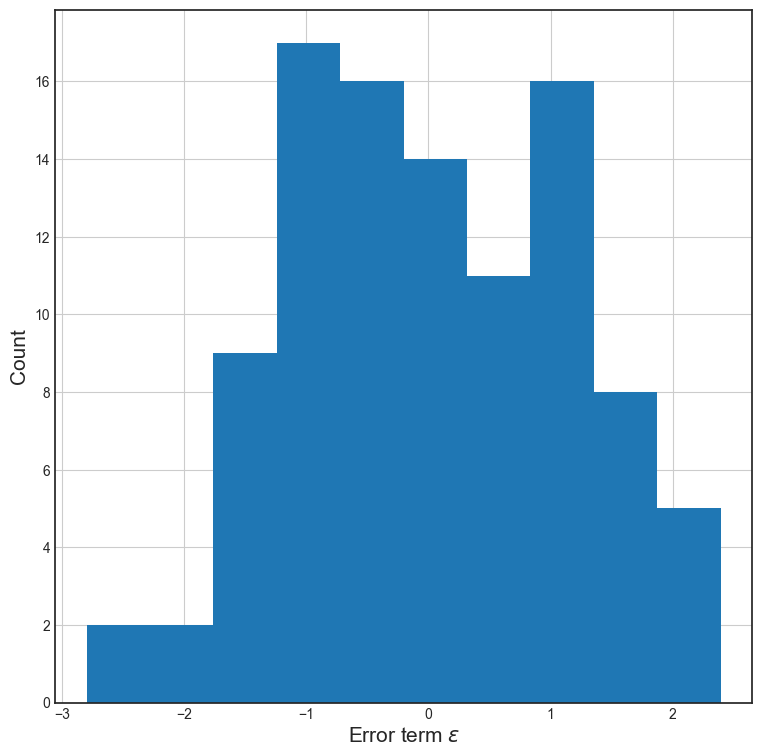

In [4]:
# error term
err = np.random.normal(0, sigma_err, N)
plt.hist(err)
plt.xlabel(r"Error term $\varepsilon$")
plt.ylabel("Count")
plt.show()

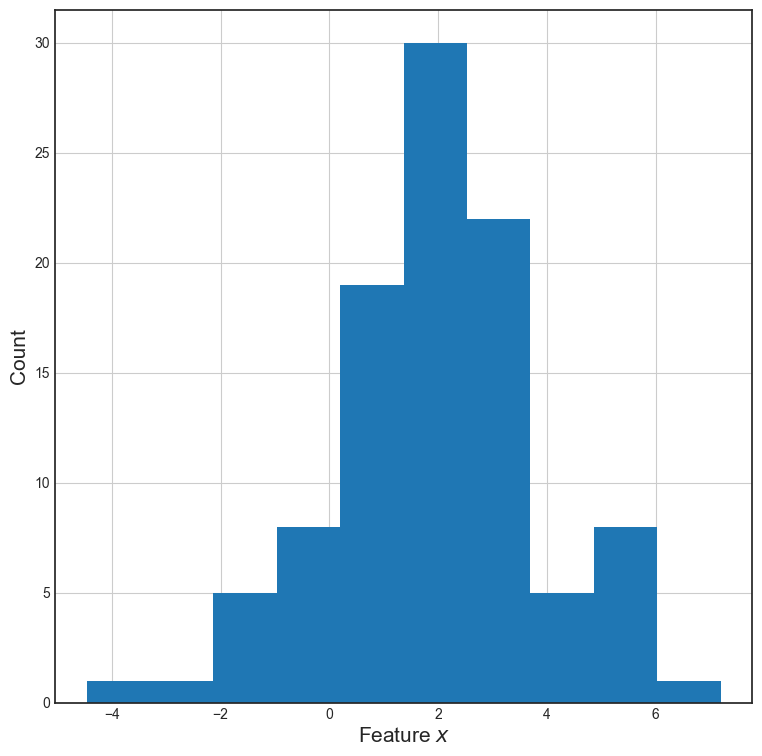

In [5]:
# features
x = np.random.normal(2, 2, N)
plt.hist(x)
plt.xlabel(r"Feature $x$")
plt.ylabel("Count")
plt.show()

In [6]:
# compute dependent variable
y = w_true * x + b_true + err

## Implementation in `sklearn`

Let's check whether the true parameters can be inferred from the data.

In [7]:
res_sklearn = sklearn.linear_model.LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1))
print(f"b_hat = {res_sklearn.intercept_[0]: .2f}")
print(f"w_hat = {res_sklearn.coef_[0][0]: .2f}")

b_hat =  3.05
w_hat = -3.01


## Manual implementation

### Class

In [8]:
class LinearRegression(object):
    def __init__(self, w0=1, b0=1, lr=0.01, optimizer="BGD", batch_size=12):
        self.lr = lr
        self.w = np.array([[w0]])
        self.b = np.array([b0])

        self.w_epoch = np.empty(shape=(0))
        self.b_epoch = np.empty(shape=(0))
        self.c_epoch = np.empty(shape=(0))
        self.ys_epoch = np.empty(shape=(2, 0))

        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epoch_counter = 0

    def cost(self, x, y):
        pred = self.predict(x)
        e = y - pred
        return np.mean(e ** 2)

    def step(self, x, y):
        pred = self.predict(x)
        e = y - pred

        # partial derivate of J with respect to w
        dJ_dw = np.mean(e * (-2 * x), axis=1)

        # partial derivate of J with respect to b
        dJ_db = np.mean(e * (-2), axis=1)

        # update w and b
        self.w = (self.w - self.lr * dJ_dw)
        self.b = self.b - self.lr * dJ_db

    def train(self, x, y, n_epochs=50_000):

        self.idx = np.arange(x.shape[0])

        w_epoch = np.zeros(n_epochs)
        b_epoch = np.zeros(n_epochs)
        c_epoch = np.zeros(n_epochs)

        for i in tqdm.tqdm(range(n_epochs)):

            if self.optimizer == "MBGD":
                np.random.shuffle(self.idx)

            w_epoch[i], b_epoch[i] = self.params()
            c_epoch[i] = self.cost(x, y)

            if self.optimizer == "BGD":
                # same as before
                self.step(x, y)

            elif self.optimizer == "SGD":
                # loop over all samples in training data
                idx_sgd = list(range(x.shape[0]))
                np.random.shuffle(idx_sgd)
                for j in idx_sgd:
                    sgd_model.step(x[j], y[j])

            elif self.optimizer == "MBGD":
                # batch samples, loop over batches
                idx_i = np.split(
                    self.idx[: self.batch_size * (len(self.idx) // self.batch_size)],
                    self.batch_size,
                )
                for idx_mb in idx_i:
                    self.step(x[idx_mb], y[idx_mb])

        self.w_epoch = np.hstack([self.w_epoch, w_epoch])
        self.b_epoch = np.hstack([self.b_epoch, b_epoch])
        self.c_epoch = np.hstack([self.c_epoch, c_epoch])
        self.epoch_counter += n_epochs

    def predict(self, x):
        return x * self.w + self.b

    def predict_epoch(x):
        n = len(self.w_epoch)
        y = np.zeros((x.shape[0], n))
        for i in range(n):
            y[:, i] = self.predict(x).T
        return y

    def params(self):
        return (self.w, self.b)

    def print_results(self, x, y):
        print(f"{self.optimizer} weight: {self.params()[0][0][0]:.4f}")
        print(f"{self.optimizer} y-intercept: {self.params()[1][0]:.4f}")
        print(f"{self.optimizer} costs: {self.cost(x, y):.4f}")

### Batch gradient descent

In [9]:
bgd_model = LinearRegression(w0=-1, b0=1, lr=0.001)
bgd_model.train(x, y, n_epochs=20_000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:01<00:00, 17628.66it/s]


In [10]:
bgd_model.print_results(x, y)

BGD weight: -3.0112
BGD y-intercept: 3.0491
BGD costs: 1.2725


### Stochastic gradient descent

In [11]:
sgd_model = LinearRegression(w0=-1, b0=1, lr=0.001, optimizer="SGD")
sgd_model.train(x, y, n_epochs=bgd_model.epoch_counter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:15<00:00, 264.82it/s]


In [12]:
sgd_model.print_results(x, y)

SGD weight: -3.0108
SGD y-intercept: 3.0476
SGD costs: 1.2725


### Mini-batch gradient descent

In [13]:
mbgd_model = LinearRegression(w0=-1, b0=1, lr=0.001, optimizer="MBGD")
mbgd_model.train(x, y, n_epochs=bgd_model.epoch_counter)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1737.60it/s]


In [14]:
mbgd_model.print_results(x, y)

MBGD weight: -3.0127
MBGD y-intercept: 3.0459
MBGD costs: 1.2725


### Compare results

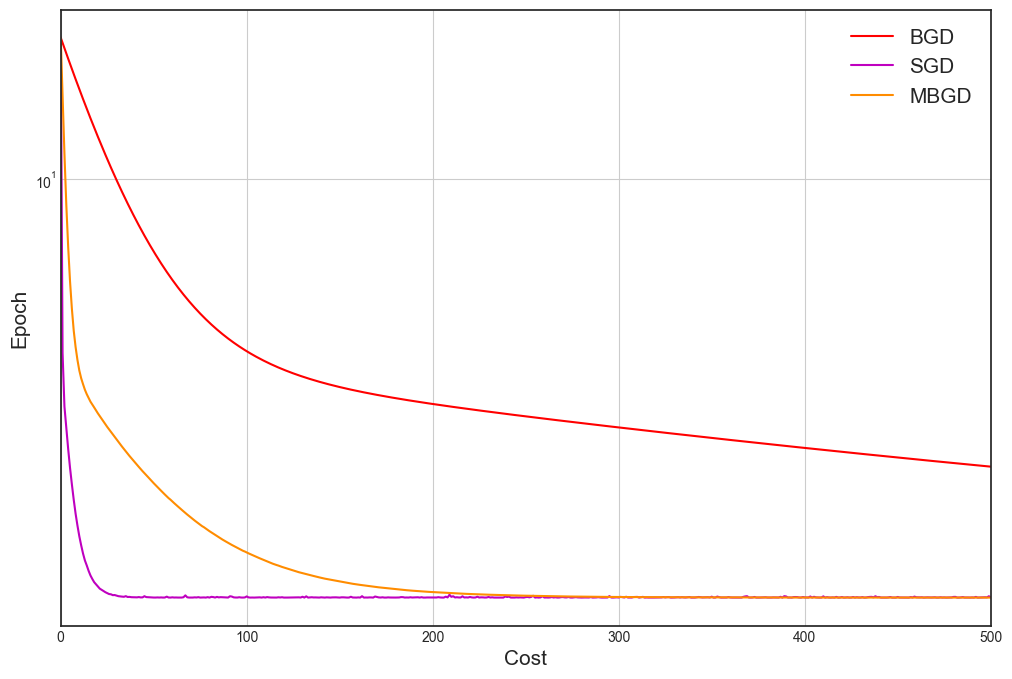

In [15]:
fig = plt.figure(figsize=(12, 8))
plt.plot(bgd_model.c_epoch, label="BGD", color="r")
plt.plot(sgd_model.c_epoch, label="SGD", color="m")
plt.plot(mbgd_model.c_epoch, label="MBGD", color="darkorange")
plt.yscale("log")
plt.xlim((0, 500))
plt.xlabel("Cost")
plt.ylabel("Epoch")
_ = plt.legend()

### Cost function and parameters

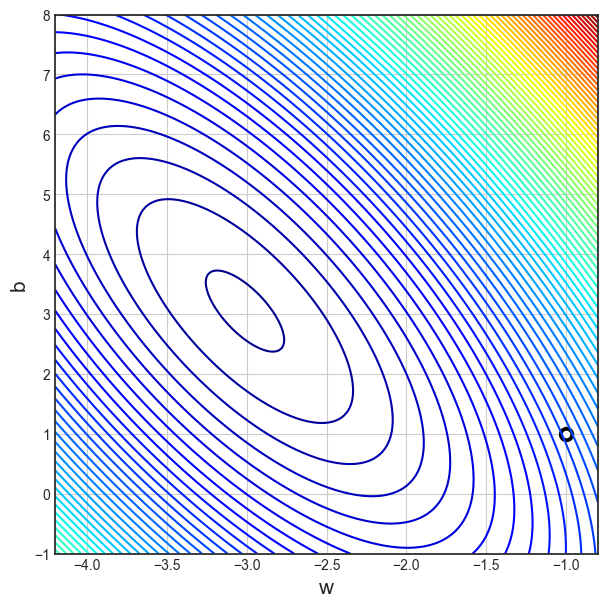

In [16]:
W, B = np.meshgrid(np.linspace(-4.2, -0.8, 200), np.linspace(-1, 8, 200))


def cost_function(x, y, w, b):
    pred = x * w + b
    e = y - pred
    return np.mean(e ** 2)


zs = np.array(
    [
        cost_function(x, y, np.array([[w]]), np.array([b]))
        for w, b in zip(np.ravel(W), np.ravel(B))
    ]
)

Z = zs.reshape(W.shape)

# contour
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.contour(W, B, Z, 100, cmap="jet")
ax1.set_xlabel("w")
ax1.set_ylabel("b")

plt.scatter(-1, 1, c="black", s=100)
plt.scatter(-1, 1, c="white", s=20)
plt.show()

In [17]:
def init_1():
    line1.set_data([], [])
    point1.set_data([], [])
    value_display1.set_text("")

    line2.set_data([], [])
    point2.set_data([], [])
    value_display2.set_text("")

    line3.set_data([], [])
    point3.set_data([], [])
    value_display3.set_text("")

    return (
        line1,
        point1,
        value_display1,
        line2,
        point2,
        value_display2,
        line3,
        point3,
        value_display3,
    )


def animate_1(i):
    p_i = p[i]
    line1.set_data(bgd_model.w_epoch[:p_i], bgd_model.b_epoch[:p_i])
    point1.set_data(bgd_model.w_epoch[p_i], bgd_model.b_epoch[p_i])
    value_display1.set_text(f"Cost(BGD)  = {bgd_model.c_epoch[p_i]:.4f}")

    line2.set_data(sgd_model.w_epoch[:p_i], sgd_model.b_epoch[:p_i])
    point2.set_data(sgd_model.w_epoch[p_i], sgd_model.b_epoch[p_i])
    value_display2.set_text(f"Cost(SGD)  = {sgd_model.c_epoch[p_i]:.4f}")

    line3.set_data(mbgd_model.w_epoch[:p_i], mbgd_model.b_epoch[:p_i])
    point3.set_data(mbgd_model.w_epoch[p_i], mbgd_model.b_epoch[p_i])
    value_display3.set_text(f"Cost(MBGD) = {mbgd_model.c_epoch[p_i]:.4f}")

    return (
        line1,
        point1,
        value_display1,
        line2,
        point2,
        value_display2,
        line3,
        point3,
        value_display3,
    )

In [18]:
linewidth = 2
marker_size = 5

p = np.hstack(
    [
        np.arange(0, 50, 1),
        np.arange(50, 200, 5),
        np.arange(200, 500, 20),
        np.arange(500, 1_000, 50),
        np.arange(1_000, 3_000, 100),
        np.arange(3_000, 10_000, 500),
        np.arange(10_000, bgd_model.epoch_counter, 1_000),
    ]
)

(line2,) = ax1.plot([], [], "m", label="SGD", linewidth=linewidth)
(point2,) = ax1.plot([], [], "*", color="m", markersize=marker_size)
value_display2 = ax1.text(0.02, 0.06, "", transform=ax1.transAxes)
value_display2.set_bbox(dict(facecolor="white", alpha=0.9, edgecolor="white"))

(line3,) = ax1.plot([], [], "darkorange", label="MBGD", linewidth=linewidth)
(point3,) = ax1.plot([], [], "*", color="darkorange", markersize=marker_size)
value_display3 = ax1.text(0.02, 0.02, "", transform=ax1.transAxes)
value_display3.set_bbox(dict(facecolor="white", alpha=0.9, edgecolor="white"))

(line1,) = ax1.plot([], [], "r", label="BGD", linewidth=linewidth)
(point1,) = ax1.plot([], [], "*", color="r", markersize=marker_size)
value_display1 = ax1.text(0.02, 0.10, "", transform=ax1.transAxes)
value_display1.set_bbox(dict(facecolor="white", alpha=0.9, edgecolor="white"))

_ = ax1.legend(loc=1)

anim1 = matplotlib.animation.FuncAnimation(
    fig1,
    animate_1,
    init_func=init_1,
    frames=len(p),
    interval=100,
    repeat_delay=60,
    blit=True,
)

_ = anim1.save("gd-contour.gif", writer="pillow", dpi=100)

<img src="gd-contour.gif" width="600">

## Additional scope

### Some questions to consider

- What are the advantages/disadvantages of the different gradient descent methods?
- What do you need to change in your implementation for other models, e.g., binary logistic regression?
- In the above picture we sum over the partial derivatives, instead of averaging the individual values (compare section [Mathematical background](#mathematical_background)). Why is that ok?

### Some notable extensions and variants of gradient descent

- Gradient descent with momentum
- Averaged gradient descent
- AdaGrad
- RMSProp
- Adam

Check the documentation of neural network frameworks (e.g., PyTorch, Keras).

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data` <br> <br>

Based on [Link1](https://towardsdatascience.com/gradient-descent-animation-1-simple-linear-regression-e49315b24672) and [Link2](https://xavierbourretsicotte.github.io/animation_ridge.html)